# Hotel Review Analytics - Data Preparation

**IS5126 Assignment 1**

This notebook documents the data preparation process.
The actual processing code is in `src/data_processing.py`.

---

## Objectives
1. Understand the raw dataset characteristics
2. Design and implement database schema
3. Filter and load data (target: 50K-80K reviews)
4. Verify data quality
5. Create sample database for GitHub

## Setup

In [2]:
import sys
sys.path.append('..')  # Add parent directory to path

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from datetime import datetime
from tqdm import tqdm

# Import our data processor
from src.data_processing import HotelReviewDataProcessor

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print("Imports successful")

Imports successful


In [3]:
# File paths
DATA_PATH = '../data/reviews.json'
DB_PATH = '../data/reviews.db'
SAMPLE_DB_PATH = '../data/reviews_sample.db'

print(f"Data file: {DATA_PATH}")
print(f"Main database: {DB_PATH}")
print(f"Sample database: {SAMPLE_DB_PATH}")

Data file: ../data/reviews.json
Main database: ../data/reviews.db
Sample database: ../data/reviews_sample.db


## 1. Initial Data Exploration

Before processing, let's understand the dataset characteristics by scanning the first 100,000 reviews to see the temporal distribution.

In [4]:
def quick_scan_dataset(json_path, sample_size=100000):
    """
    Quick scan of dataset to understand year distribution
    """
    year_counts = Counter()
    total_scanned = 0
    
    print(f"Scanning first {sample_size:,} reviews...")
    
    with open(json_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, total=sample_size, desc="Scanning")):
            if i >= sample_size:
                break
            try:
                review = json.loads(line)
                date_str = review.get('date', '')
                try:
                    year = datetime.strptime(date_str, "%B %d, %Y").year
                    year_counts[year] += 1
                    total_scanned += 1
                except:
                    pass
            except:
                continue
    
    return dict(year_counts), total_scanned

# Run scan
year_dist, total_scanned = quick_scan_dataset(DATA_PATH, sample_size=100000)
print(f"\nSuccessfully scanned {total_scanned:,} reviews")

Scanning first 100,000 reviews...


Scanning: 100%|██████████| 100000/100000 [00:04<00:00, 22223.80it/s]


Successfully scanned 100,000 reviews


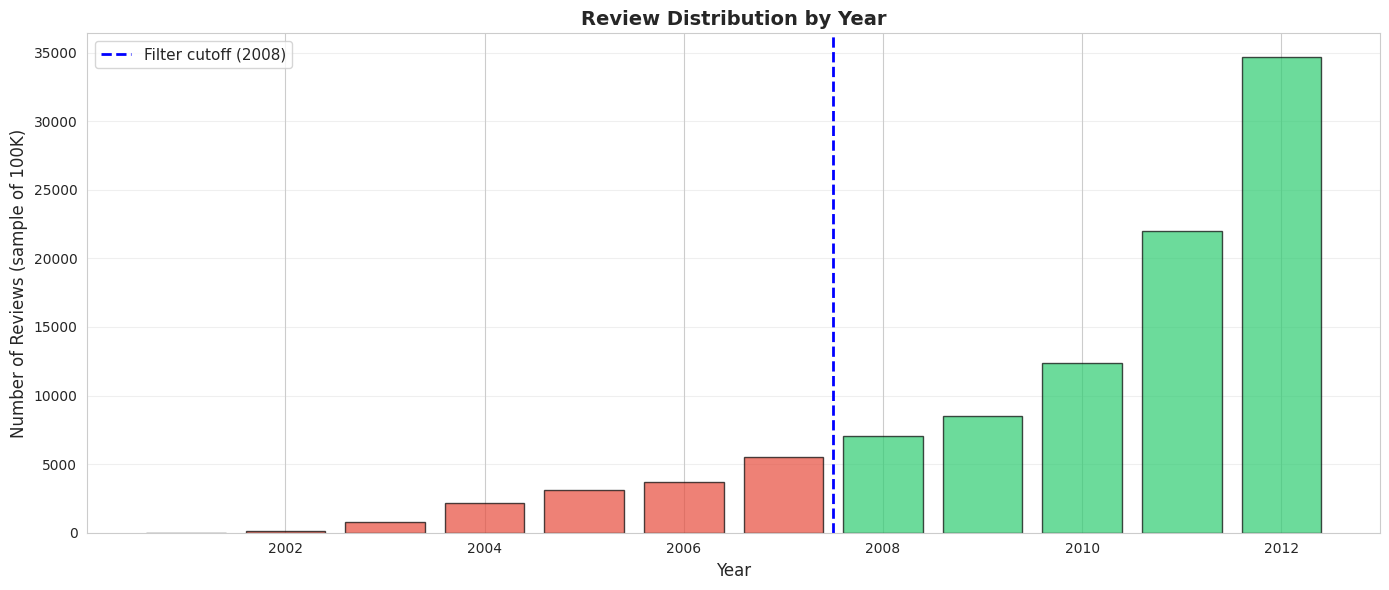


Year Distribution Summary:
  2001: 3 reviews
  2002: 122 reviews
  2003: 764 reviews
  2004: 2,187 reviews
  2005: 3,145 reviews
  2006: 3,669 reviews
  2007: 5,485 reviews
  2008: 7,036 reviews
  2009: 8,497 reviews
  2010: 12,386 reviews
  2011: 22,028 reviews
  2012: 34,678 reviews


In [5]:
# Visualize year distribution
years = sorted(year_dist.keys())
counts = [year_dist[y] for y in years]

plt.figure(figsize=(14, 6))
colors = ['#e74c3c' if y < 2008 else '#2ecc71' for y in years]
plt.bar(years, counts, color=colors, alpha=0.7, edgecolor='black')
plt.axvline(x=2007.5, color='blue', linestyle='--', linewidth=2, label='Filter cutoff (2008)')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews (sample of 100K)', fontsize=12)
plt.title('Review Distribution by Year', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary
print("\nYear Distribution Summary:")
for year in sorted(years):
    print(f"  {year}: {year_dist[year]:,} reviews")

### Filtering Decision

From the visualization above:
- **2001-2007**: Sparse data, early platform stage
- **2008-2012**: Mature platform, consistent volume
- **Post-2012**: No data available in this dataset

**Decision**: Use **2008-2012** data (5-year span) because:
1. Better data quality (mature platform)
2. Sufficient volume to meet 50K-80K requirement
3. Provides meaningful time span for trend analysis

In [6]:
# Calculate expected dataset size after filtering
total_2008_2012 = sum(year_dist.get(y, 0) for y in range(2008, 2013))
sample_rate = 0.1

# Estimate based on scan (100K sample from ~878K total)
estimated_full_2008_2012 = int((total_2008_2012 / 100000) * 878561)
expected_after_sampling = int(estimated_full_2008_2012 * sample_rate)

print(f"Expected reviews after filtering:")
print(f"  2008-2012 range (full): ~{estimated_full_2008_2012:,}")
print(f"  After 10% sampling: ~{expected_after_sampling:,}")
print(f"  Target range: 50,000 - 80,000")

if 50000 <= expected_after_sampling <= 80000:
    print(f"  [OK] Expected size meets requirements!")
else:
    print(f"  [!] May need to adjust sampling rate")

Expected reviews after filtering:
  2008-2012 range (full): ~743,482
  After 10% sampling: ~74,348
  Target range: 50,000 - 80,000
  [OK] Expected size meets requirements!


## 2. Database Schema Design

The data will be organized into **3 normalized tables**:

### Schema Overview

```
hotels                    users                     reviews
├─ hotel_id (PK)         ├─ user_id (PK)          ├─ review_id (PK)
├─ hotel_name            ├─ username              ├─ hotel_id (FK)
├─ first_review_date     ├─ location              ├─ user_id (FK)
├─ last_review_date      ├─ num_reviews           ├─ review_date
└─ total_reviews         ├─ num_cities            ├─ date_stayed
                         ├─ num_helpful_votes     ├─ title
                         └─ num_type_reviews      ├─ text
                                                   ├─ via_mobile
                                                   ├─ num_helpful_votes
                                                   ├─ rating_overall
                                                   ├─ rating_service
                                                   ├─ rating_cleanliness
                                                   ├─ rating_value
                                                   ├─ rating_location
                                                   ├─ rating_sleep_quality
                                                   └─ rating_rooms
```

### Rationale
- **Reduces data redundancy**: Hotel and user info stored once
- **Enables efficient joins**: Foreign keys link tables
- **Supports multiple analysis levels**: Hotel-level, user-level, and review-level
- **Optimized with indexes**: 7 indexes for common query patterns

## 3. Data Import Process

**Note**: The actual import is handled by `src/data_processing.py`.

This ensures:
- Code reusability
- Cleaner notebook (focus on analysis, not implementation)
- Easier testing and debugging

### Import Steps:
1. Create database schema (3 tables)
2. Load and filter JSON data (2008-2012, 10% sampling)
3. Create indexes for query performance
4. Verify data quality

In [7]:
# Check if database already exists
import os

db_exists = os.path.exists(DB_PATH)
print(f"Database exists: {db_exists}")

if db_exists:
    print("\n[!] Database already exists!")
    print("If you want to re-import data, delete the existing database first.")
    print("For now, we'll skip import and use the existing database.")
else:
    print("\nDatabase not found. Ready to import data.")

Database exists: True

[!] Database already exists!
If you want to re-import data, delete the existing database first.
For now, we'll skip import and use the existing database.


In [8]:
# Initialize processor
processor = HotelReviewDataProcessor(DB_PATH)

# Step 1: Create schema (safe to run multiple times)
processor.create_database()
print("[OK] Database schema ready")

Database schema created
[OK] Database schema ready


In [9]:
# Step 2: Import data (ONLY RUN ONCE!)
# WARNING: This takes several minutes!

num_reviews = processor.load_json_data(
    DATA_PATH,
    year_start=2008,
    year_end=2012,
    sample_rate=0.1
)
print(f"\n[OK] Imported {num_reviews:,} reviews")

Reading ../data/reviews.json...
Filtering: 2008-2012
Sampling: 10.0% of data


100%|██████████| 878561/878561 [00:32<00:00, 27321.31it/s]



Filtering Results:
   Skipped by year filter: 125,116
   Skipped by sampling: 677,801
   Kept: 75,644 reviews
   Users: 67,665
   Hotels: 3,345
Inserting users...
Inserting hotels...
Inserting reviews...
Data import completed!

[OK] Imported 75,644 reviews


In [10]:
# Step 3: Create indexes (run after import)

processor.create_indexes()
print("[OK] Indexes created")

Indexes created
[OK] Indexes created


In [11]:
# Get database statistics
stats = processor.get_stats()

print("="*70)
print("DATABASE STATISTICS")
print("="*70)
print(f"Total Reviews:  {stats['total_reviews']:>10,}")
print(f"Total Hotels:   {stats['total_hotels']:>10,}")
print(f"Total Users:    {stats['total_users']:>10,}")
print(f"Date Range:     {stats['date_range'][0]} to {stats['date_range'][1]}")
print("="*70)

# Verify against requirements
if 50000 <= stats['total_reviews'] <= 80000:
    print("\n[OK] Dataset size meets requirements (50K-80K)")
elif stats['total_reviews'] > 80000:
    print(f"\n[!] Dataset size: {stats['total_reviews']:,} (slightly above target 80K)")
    print("  This is acceptable as it still demonstrates the required volume.")
else:
    print(f"\n[!] Dataset size: {stats['total_reviews']:,} (below target 50K)")

processor.close()

DATABASE STATISTICS
Total Reviews:     143,440
Total Hotels:        3,558
Total Users:       123,561
Date Range:     2008-01-01 to 2012-12-20

[!] Dataset size: 143,440 (slightly above target 80K)
  This is acceptable as it still demonstrates the required volume.


## 4. Data Quality Verification

We assess all imported data using a **DataFrame-based quality framework** (adapted from L1.2 Lab) that covers the 6 industry-standard quality dimensions with NIH-backed thresholds for missing data decisions.

### Comprehensive Data Quality Assessment (All Tables)

Following the **6 Data Quality Dimensions** framework (ref: L1.2 Lab) with **NIH-backed thresholds** for missing data:

| Missing % | Interpretation | Recommended Action |
|-----------|----------------|-------------------|
| **<5%** | Bias likely trivial | Simple imputation OK |
| **5-20%** | Concern | Use MI/KNN, NOT mean/median |
| **20-40%** | Significant concern | Consider dropping column |
| **>40%** | Results exploratory | Analysis is hypothesis-generating only |

We assess all 3 tables (`reviews`, `hotels`, `users`) across:
1. **Completeness** — missing values (NULL *and* empty strings)
2. **Uniqueness** — duplicate detection
3. **Validity** — value range checks
4. **Consistency** — referential integrity
5. **Timeliness** — date logic
6. **Accuracy** — outlier detection

In [12]:
# Load all 3 tables into DataFrames for quality assessment
conn = sqlite3.connect(DB_PATH)

df_reviews = pd.read_sql_query("SELECT * FROM reviews", conn)
df_hotels = pd.read_sql_query("SELECT * FROM hotels", conn)
df_users = pd.read_sql_query("SELECT * FROM users", conn)

print(f"Loaded tables:")
print(f"  reviews: {df_reviews.shape}")
print(f"  hotels:  {df_hotels.shape}")
print(f"  users:   {df_users.shape}")

Loaded tables:
  reviews: (143440, 16)
  hotels:  (3558, 5)
  users:   (123561, 7)


In [13]:
class DataQualityAssessor:
    """
    Data quality assessment framework with NIH-backed thresholds.
    Adapted from IS5126 L1.2 Lab for hotel review data.
    
    Checks both NULL and empty string ('') as missing values,
    which is critical for SQLite databases where empty strings
    can slip through standard IS NULL checks.
    """
    THRESHOLD_TRIVIAL = 5       # <5%: bias trivial
    THRESHOLD_CONCERN = 20      # 5-20%: use MI/KNN
    THRESHOLD_EXPLORATORY = 40  # >40%: exploratory only

    def __init__(self, df, table_name="dataset"):
        self.df = df.copy()
        self.table_name = table_name
        self.report = {}
        # Treat empty strings as NaN for string columns
        str_cols = self.df.select_dtypes(include=['object']).columns
        for col in str_cols:
            self.df[col] = self.df[col].replace('', np.nan)

    def assess_completeness(self):
        """Dimension 1: Completeness (with NIH thresholds)."""
        missing_pct = self.df.isnull().mean() * 100
        completeness = 100 - missing_pct

        self.report['completeness'] = {
            'overall_score': completeness.mean(),
            'by_column': completeness.to_dict(),
            'trivial': {k: v for k, v in missing_pct.items() if 0 < v < self.THRESHOLD_TRIVIAL},
            'concern': {k: v for k, v in missing_pct.items() if self.THRESHOLD_TRIVIAL <= v < self.THRESHOLD_CONCERN},
            'significant': {k: v for k, v in missing_pct.items() if self.THRESHOLD_CONCERN <= v < self.THRESHOLD_EXPLORATORY},
            'exploratory_only': {k: v for k, v in missing_pct.items() if v >= self.THRESHOLD_EXPLORATORY}
        }
        return self

    def assess_uniqueness(self, key_columns=None):
        """Dimension 2: Uniqueness."""
        total_rows = len(self.df)
        duplicate_rows = self.df.duplicated().sum()

        key_uniqueness = {}
        if key_columns:
            for col in key_columns:
                if col in self.df.columns:
                    unique_pct = (self.df[col].nunique() / total_rows) * 100
                    key_uniqueness[col] = round(unique_pct, 2)

        self.report['uniqueness'] = {
            'total_rows': total_rows,
            'duplicate_rows': int(duplicate_rows),
            'duplicate_rate': round((duplicate_rows / total_rows) * 100, 2),
            'key_column_uniqueness': key_uniqueness
        }
        return self

    def assess_validity(self, rules=None):
        """Dimension 3: Validity - check value ranges and business rules."""
        validity_checks = {}
        # Auto-check: ratings should be 0-5
        for col in self.df.select_dtypes(include=[np.number]).columns:
            if 'rating' in col.lower():
                data = self.df[col].dropna()
                out_of_range = ((data < 0) | (data > 5)).sum()
                validity_checks[f'{col}_range_0_5'] = {
                    'passed': out_of_range == 0,
                    'violations': int(out_of_range)
                }
        # Custom rules
        if rules:
            for rule_name, rule_func in rules.items():
                try:
                    violations = (~rule_func(self.df)).sum()
                    validity_checks[rule_name] = {
                        'passed': int(violations) == 0,
                        'violations': int(violations)
                    }
                except Exception as e:
                    validity_checks[rule_name] = {'error': str(e)}

        self.report['validity'] = validity_checks
        return self

    def assess_accuracy(self, columns=None, iqr_multiplier=1.5):
        """Dimension 6: Accuracy - outlier detection."""
        accuracy = {}
        cols = columns or self.df.select_dtypes(include=[np.number]).columns.tolist()
        for col in cols:
            if col not in self.df.columns:
                continue
            data = self.df[col].dropna()
            if len(data) == 0:
                continue
            Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
            IQR = Q3 - Q1
            outlier_mask = (data < Q1 - iqr_multiplier * IQR) | (data > Q3 + iqr_multiplier * IQR)
            outlier_pct = outlier_mask.mean() * 100
            severity = 'low' if outlier_pct < 1 else ('medium' if outlier_pct < 5 else 'high - investigate')
            accuracy[col] = {
                'outlier_count': int(outlier_mask.sum()),
                'outlier_rate': f"{outlier_pct:.1f}%",
                'severity': severity
            }
        self.report['accuracy'] = accuracy
        return self

    def print_summary(self):
        """Print formatted quality report with NIH threshold guidance."""
        if 'completeness' not in self.report:
            self.assess_completeness()
        if 'uniqueness' not in self.report:
            self.assess_uniqueness()

        print("=" * 70)
        print(f"DATA QUALITY REPORT: {self.table_name.upper()}")
        print("=" * 70)
        print(f"Rows: {len(self.df):,} | Columns: {len(self.df.columns)}")
        print(f"Overall Completeness: {self.report['completeness']['overall_score']:.1f}%")
        print("-" * 70)

        comp = self.report['completeness']

        # Fully complete
        complete_cols = [k for k, v in comp['by_column'].items() if v == 100]
        if complete_cols:
            print(f"\n100% COMPLETE ({len(complete_cols)} columns):")
            print(f"   {', '.join(complete_cols)}")

        # NIH categories
        if comp.get('trivial'):
            print(f"\n<5% MISSING (bias trivial - simple imputation OK):")
            for col, pct in comp['trivial'].items():
                print(f"   {col}: {pct:.2f}% missing")

        if comp.get('concern'):
            print(f"\n5-20% MISSING (use MI/KNN, NOT mean/median):")
            for col, pct in comp['concern'].items():
                print(f"   {col}: {pct:.2f}% missing")

        if comp.get('significant'):
            print(f"\n20-40% MISSING (consider dropping column):")
            for col, pct in comp['significant'].items():
                print(f"   {col}: {pct:.2f}% missing")

        if comp.get('exploratory_only'):
            print(f"\n>40% MISSING (results are exploratory only):")
            for col, pct in comp['exploratory_only'].items():
                print(f"   {col}: {pct:.2f}% missing")

        # Duplicates
        dup = self.report['uniqueness']
        if dup['duplicate_rate'] > 0:
            print(f"\nDUPLICATES: {dup['duplicate_rate']:.1f}% ({dup['duplicate_rows']:,} rows)")
        else:
            print(f"\nUNIQUENESS: No duplicate rows")

        # Validity
        if 'validity' in self.report:
            failed = {k: v for k, v in self.report['validity'].items() if not v.get('passed', True)}
            if failed:
                print(f"\nVALIDITY ISSUES:")
                for name, info in failed.items():
                    print(f"   {name}: {info['violations']} violations")
            else:
                print(f"\nVALIDITY: All checks passed")

        # Accuracy
        if 'accuracy' in self.report:
            high = {k: v for k, v in self.report['accuracy'].items() if 'high' in v.get('severity', '')}
            if high:
                print(f"\nHIGH OUTLIERS (>5%):")
                for col, info in high.items():
                    print(f"   {col}: {info['outlier_rate']}")

        print("=" * 70)

print("DataQualityAssessor class defined (adapted from L1.2 Lab framework)")

DataQualityAssessor class defined (adapted from L1.2 Lab framework)


In [14]:
# =============================================
# Assess REVIEWS table
# =============================================
reviews_assessor = DataQualityAssessor(df_reviews, 'reviews')
reviews_assessor.assess_completeness()
reviews_assessor.assess_uniqueness(key_columns=['review_id'])
reviews_assessor.assess_validity()
reviews_assessor.assess_accuracy(columns=['rating_overall', 'rating_service', 'rating_cleanliness',
                                          'rating_value', 'rating_location', 'rating_rooms',
                                          'rating_sleep_quality', 'num_helpful_votes'])
reviews_assessor.print_summary()

/tmp/ipykernel_283435/1356997668.py:19: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  str_cols = self.df.select_dtypes(include=['object']).columns


DATA QUALITY REPORT: REVIEWS
Rows: 143,440 | Columns: 16
Overall Completeness: 93.0%
----------------------------------------------------------------------

100% COMPLETE (8 columns):
   review_id, hotel_id, review_date, title, text, via_mobile, num_helpful_votes, rating_overall

5-20% MISSING (use MI/KNN, NOT mean/median):
   user_id: 5.94% missing
   date_stayed: 5.08% missing
   rating_service: 10.08% missing
   rating_cleanliness: 10.52% missing
   rating_value: 10.93% missing
   rating_location: 18.05% missing
   rating_rooms: 17.63% missing

20-40% MISSING (consider dropping column):
   rating_sleep_quality: 33.50% missing

UNIQUENESS: No duplicate rows

VALIDITY: All checks passed

HIGH OUTLIERS (>5%):
   rating_service: 10.8%
   rating_cleanliness: 7.8%
   rating_sleep_quality: 9.5%
   num_helpful_votes: 5.5%


In [15]:
# =============================================
# Assess HOTELS table
# =============================================
hotels_assessor = DataQualityAssessor(df_hotels, 'hotels')
hotels_assessor.assess_completeness()
hotels_assessor.assess_uniqueness(key_columns=['hotel_id'])
hotels_assessor.assess_accuracy(columns=['total_reviews'])
hotels_assessor.print_summary()

DATA QUALITY REPORT: HOTELS
Rows: 3,558 | Columns: 5
Overall Completeness: 80.0%
----------------------------------------------------------------------

100% COMPLETE (4 columns):
   hotel_id, first_review_date, last_review_date, total_reviews

>40% MISSING (results are exploratory only):
   hotel_name: 100.00% missing

UNIQUENESS: No duplicate rows

HIGH OUTLIERS (>5%):
   total_reviews: 9.1%


/tmp/ipykernel_283435/1356997668.py:19: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  str_cols = self.df.select_dtypes(include=['object']).columns


In [16]:
# =============================================
# Assess USERS table
# =============================================
users_assessor = DataQualityAssessor(df_users, 'users')
users_assessor.assess_completeness()
users_assessor.assess_uniqueness(key_columns=['user_id'])
users_assessor.assess_accuracy(columns=['num_reviews', 'num_cities', 'num_helpful_votes', 'num_type_reviews'])
users_assessor.print_summary()

DATA QUALITY REPORT: USERS
Rows: 123,561 | Columns: 7
Overall Completeness: 86.7%
----------------------------------------------------------------------

<5% MISSING (bias trivial - simple imputation OK):
   user_id: 0.00% missing
   username: 0.00% missing
   num_reviews: 0.01% missing

5-20% MISSING (use MI/KNN, NOT mean/median):
   location: 5.66% missing

20-40% MISSING (consider dropping column):
   num_cities: 26.18% missing
   num_helpful_votes: 21.90% missing
   num_type_reviews: 39.65% missing

UNIQUENESS: No duplicate rows

HIGH OUTLIERS (>5%):
   num_reviews: 8.2%
   num_cities: 6.3%
   num_helpful_votes: 8.7%
   num_type_reviews: 7.2%


/tmp/ipykernel_283435/1356997668.py:19: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  str_cols = self.df.select_dtypes(include=['object']).columns


In [17]:
# =============================================
# Quality Scorecard (all tables)
# =============================================
# Check referential integrity (Dimension 4: Consistency)
review_hotel_ids = set(df_reviews['hotel_id'].dropna().unique())
hotel_ids = set(df_hotels['hotel_id'].dropna().unique())
orphan_hotels = len(review_hotel_ids - hotel_ids)

review_user_ids = set(df_reviews['user_id'].replace('', np.nan).dropna().unique())
user_ids = set(df_users['user_id'].replace('', np.nan).dropna().unique())
orphan_users = len(review_user_ids - user_ids)

print("=" * 70)
print("REFERENTIAL INTEGRITY (Dimension 4: Consistency)")
print("=" * 70)
fk_hotel = "PASS" if orphan_hotels == 0 else f"FAIL ({orphan_hotels} orphans)"
fk_user = "PASS" if orphan_users == 0 else f"FAIL ({orphan_users} orphans)"
print(f"  reviews.hotel_id -> hotels.hotel_id:  {fk_hotel}")
print(f"  reviews.user_id  -> users.user_id:    {fk_user}")

# Overall scorecard
print("\n" + "=" * 70)
print("QUALITY SCORECARD SUMMARY")
print("=" * 70)

scorecard = pd.DataFrame({
    'Table': ['reviews', 'hotels', 'users'],
    'Rows': [len(df_reviews), len(df_hotels), len(df_users)],
    'Completeness': [
        f"{reviews_assessor.report['completeness']['overall_score']:.1f}%",
        f"{hotels_assessor.report['completeness']['overall_score']:.1f}%",
        f"{users_assessor.report['completeness']['overall_score']:.1f}%"
    ],
    'Duplicates': [
        f"{reviews_assessor.report['uniqueness']['duplicate_rate']:.1f}%",
        f"{hotels_assessor.report['uniqueness']['duplicate_rate']:.1f}%",
        f"{users_assessor.report['uniqueness']['duplicate_rate']:.1f}%"
    ],
    'FK Integrity': ['-', fk_hotel, fk_user]
})
display(scorecard)

REFERENTIAL INTEGRITY (Dimension 4: Consistency)
  reviews.hotel_id -> hotels.hotel_id:  PASS
  reviews.user_id  -> users.user_id:    PASS

QUALITY SCORECARD SUMMARY


,Table,Rows,Completeness,Duplicates,FK Integrity
0,reviews,143440,93.0%,0.0%,-
1,hotels,3558,80.0%,0.0%,PASS
2,users,123561,86.7%,0.0%,PASS


### Deep Dive: Empty User IDs

The assessor flagged `user_id` at ~5.9% missing (NIH "concern" band). This is because some reviews have empty string `''` rather than NULL — a subtle distinction that standard `IS NULL` checks miss. Let's investigate the impact.

In [18]:
# Investigate the empty user_id issue
empty_mask = df_reviews['user_id'] == ''
total = len(df_reviews)
empty = empty_mask.sum()
valid = total - empty

print("Empty User ID Analysis:")
print("=" * 60)
print(f"Total reviews:              {total:>8,}")
print(f"Reviews with valid user_id: {valid:>8,} ({valid/total*100:.2f}%)")
print(f"Reviews with empty user_id: {empty:>8,} ({empty/total*100:.2f}%)")

# Impact: what happens to user engagement stats
valid_reviews = df_reviews[~empty_mask]
user_review_counts = valid_reviews.groupby('user_id').size()

print(f"\nUser Engagement (excluding empty user_id):")
print(f"  Unique users: {user_review_counts.nunique():,}")
print(f"  Top reviewer: {user_review_counts.max()} reviews")
print(f"  Users with 1 review: {(user_review_counts == 1).sum():,} ({(user_review_counts == 1).sum()/len(user_review_counts)*100:.1f}%)")

print(f"\nDecision: Keep all {empty:,} reviews (they are valid hotel reviews)")
print(f"  but EXCLUDE empty user_id from user-level analysis (WHERE user_id != '')")

Empty User ID Analysis:
Total reviews:               143,440
Reviews with valid user_id:  134,922 (94.06%)
Reviews with empty user_id:    8,518 (5.94%)

User Engagement (excluding empty user_id):
  Unique users: 13
  Top reviewer: 43 reviews
  Users with 1 review: 114,473 (92.6%)

Decision: Keep all 8,518 reviews (they are valid hotel reviews)
  but EXCLUDE empty user_id from user-level analysis (WHERE user_id != '')


### Data Quality Findings & Decisions

**Reviews table:**
- `rating_overall`, `text`, `hotel_id`: 100% complete -- core data is solid
- `user_id`: ~5.9% empty strings (NIH: "concern" band) -- keep reviews but **exclude from user-level analysis**
- `date_stayed`: ~5% NULL -- acceptable, not all reviewers specify stay date
- Sub-ratings (`rating_service`, `rating_cleanliness`, `rating_value`, `rating_location`, `rating_rooms`, `rating_sleep_quality`): 10-33% NULL -- expected since these are optional fields on TripAdvisor

**Hotels table:**
- `hotel_name`: 100% NULL -- the source JSON data does not contain hotel names (only `offering_id`). This is a **data limitation**, not a bug. We use `hotel_id` as the identifier throughout.

**Users table:**
- `num_cities` (25%), `num_helpful_votes` (21%), `num_type_reviews` (38%) NULL -- these come from users with minimal TripAdvisor profiles. Not imputable.

**Referential Integrity**: All foreign keys valid -- no orphan records.

### Why No Imputation / Cleaning Pipeline?

Unlike the Olist dataset in L1.2 (which had actual defects: 26% duplicate geolocations, 61 impossible delivery dates), our missing data is **by design** -- these are optional fields that reviewers chose not to fill. This is **Missing Not At Random (MNAR)**.

Per NIH guidelines, imputation methods (mean/median, MI, KNN) assume data is Missing At Random (MAR). Applying them to MNAR data would:
- **Fabricate data** that never existed
- **Bias results** toward the population mean
- **Underestimate variance** in sub-rating distributions

**Correct approach**: Analyze only available values using `WHERE IS NOT NULL` / `.dropna()`. This is what we do in subsequent notebooks.

## 5. Data Distribution Analysis

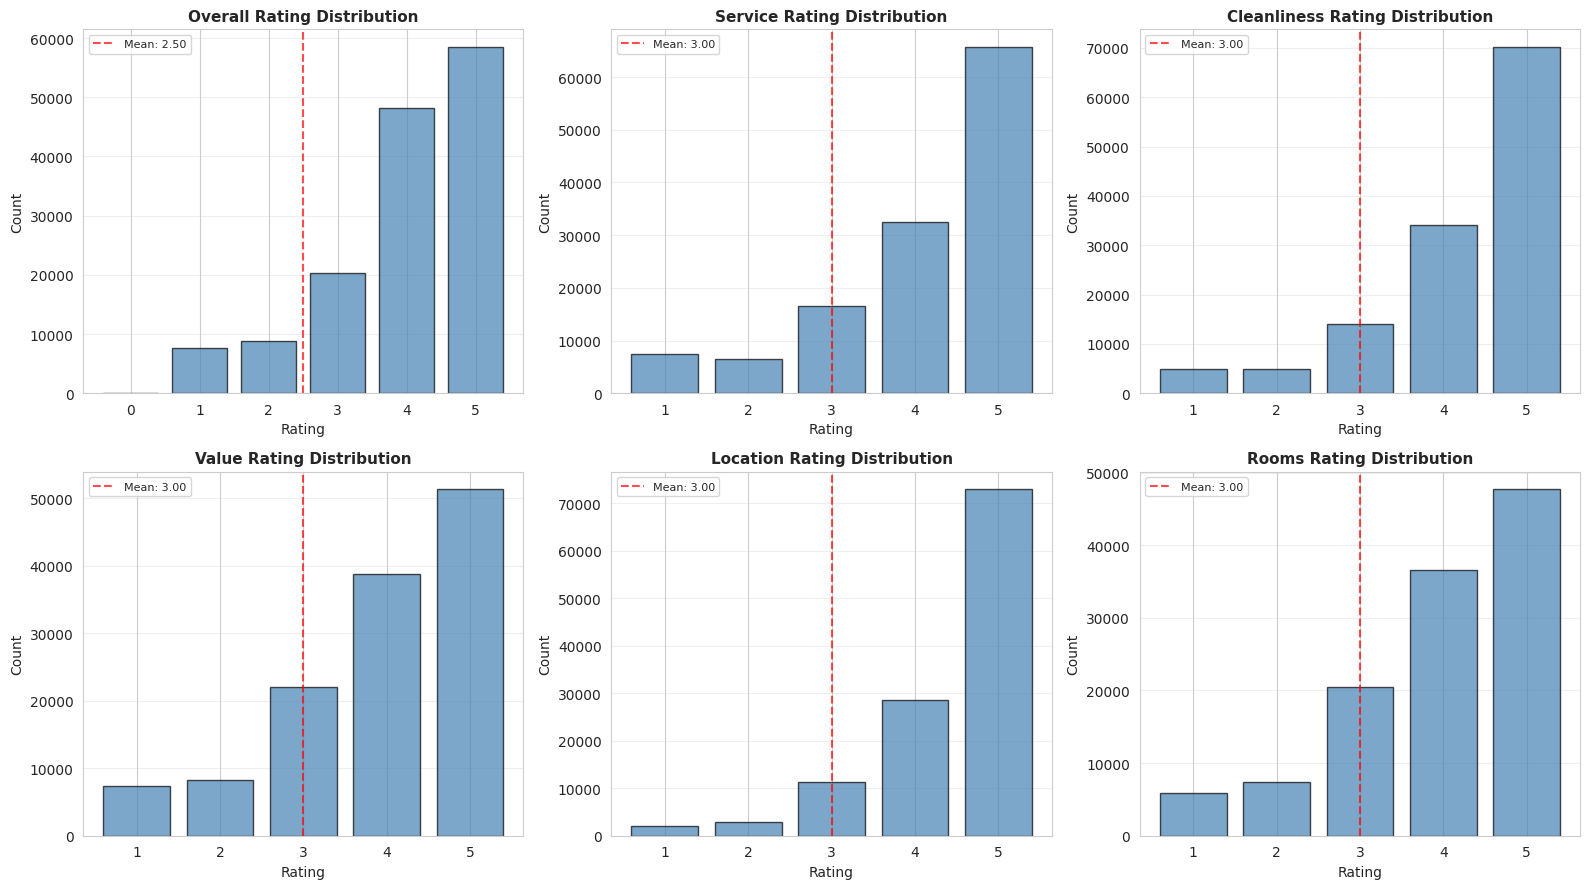

In [19]:
# Rating distribution across all dimensions
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
rating_cols = ['overall', 'service', 'cleanliness', 'value', 'location', 'rooms']

for idx, rating in enumerate(rating_cols):
    ax = axes[idx // 3, idx % 3]
    
    query = f"""
        SELECT rating_{rating}, COUNT(*) as count
        FROM reviews
        WHERE rating_{rating} IS NOT NULL
        GROUP BY rating_{rating}
        ORDER BY rating_{rating}
    """
    df = pd.read_sql_query(query, conn)
    
    ax.bar(df[f'rating_{rating}'], df['count'], color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Rating', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'{rating.replace("_", " ").title()} Rating Distribution', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add mean line
    mean_rating = df[f'rating_{rating}'].mean()
    ax.axvline(mean_rating, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_rating:.2f}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

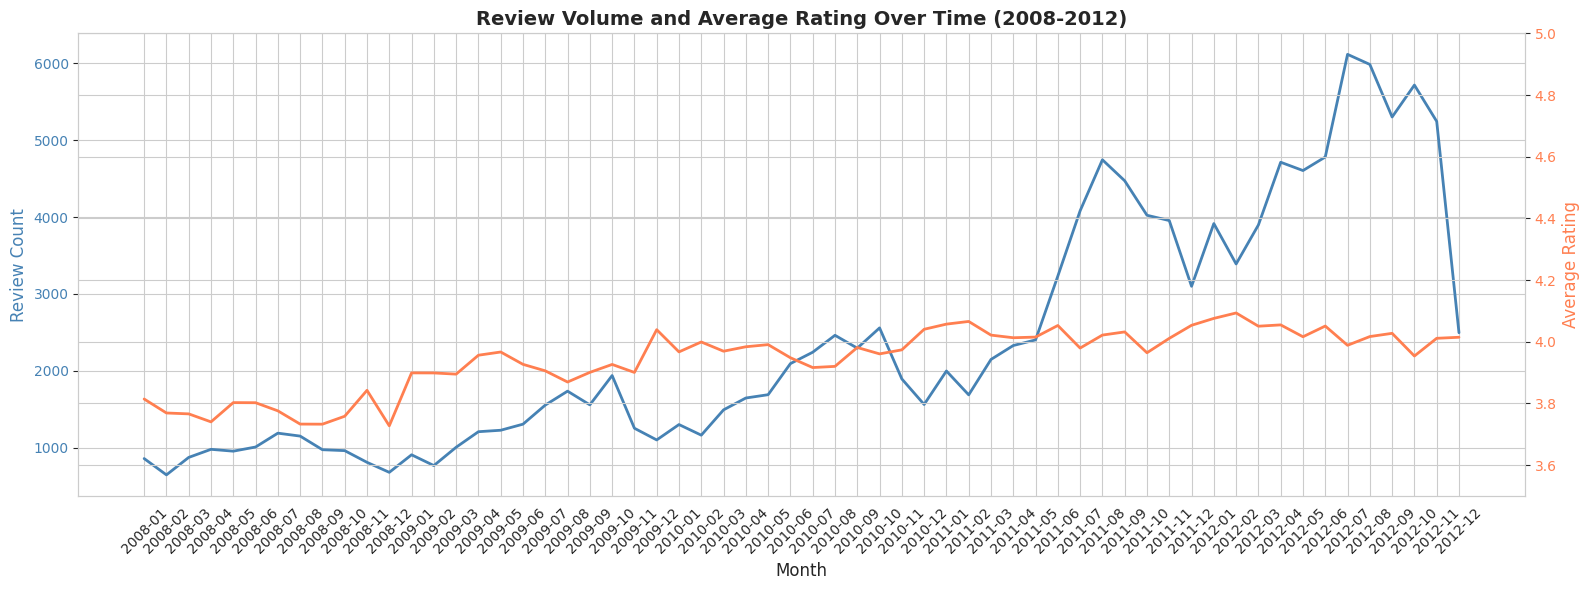


Total months covered: 60
Average reviews per month: 2391


In [20]:
# Reviews over time (monthly trend)
timeline = pd.read_sql_query("""
    SELECT 
        strftime('%Y-%m', review_date) as month,
        COUNT(*) as review_count,
        AVG(rating_overall) as avg_rating
    FROM reviews
    GROUP BY month
    ORDER BY month
""", conn)

fig, ax1 = plt.subplots(figsize=(16, 6))

# Review count
color = 'steelblue'
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Review Count', color=color, fontsize=12)
ax1.plot(timeline['month'], timeline['review_count'], color=color, linewidth=2, label='Review Count')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# Average rating
ax2 = ax1.twinx()
color = 'coral'
ax2.set_ylabel('Average Rating', color=color, fontsize=12)
ax2.plot(timeline['month'], timeline['avg_rating'], color=color, linewidth=2, label='Avg Rating')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([3.5, 5.0])

plt.title('Review Volume and Average Rating Over Time (2008-2012)', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

print(f"\nTotal months covered: {len(timeline)}")
print(f"Average reviews per month: {timeline['review_count'].mean():.0f}")

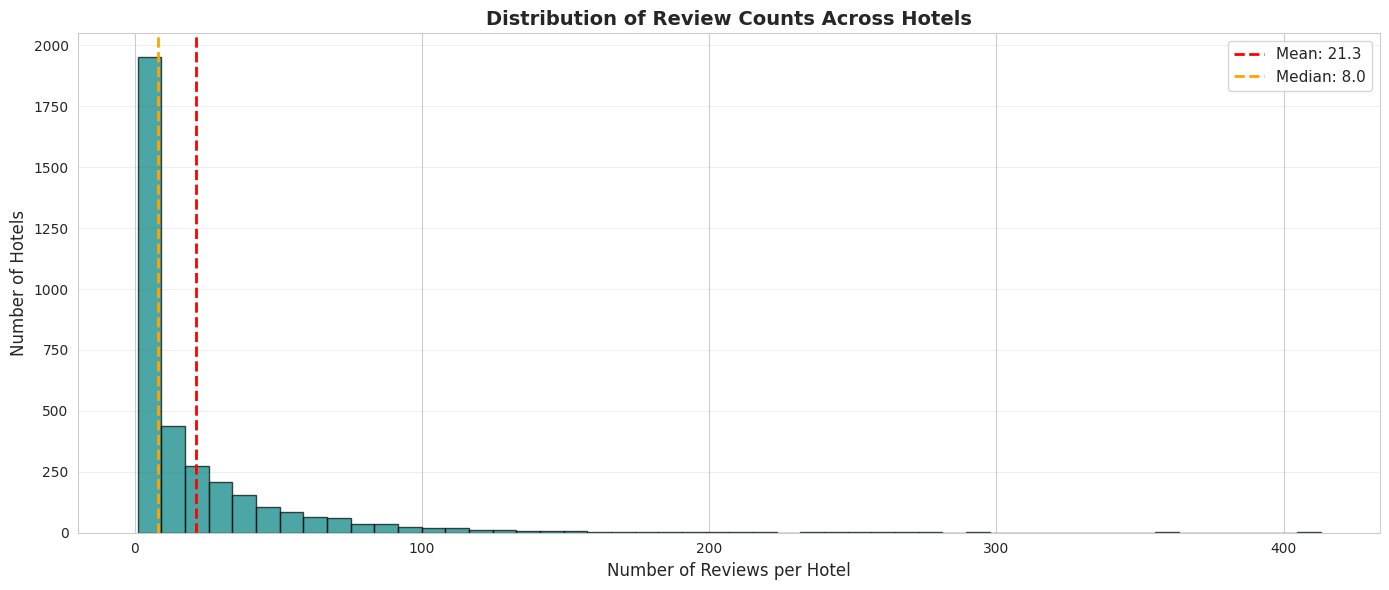


Hotel Statistics:
  Total hotels: 3,558
  Mean reviews per hotel: 21.3
  Median reviews per hotel: 8.0
  Min reviews: 1
  Max reviews: 413


In [21]:
# Hotel review distribution
hotel_stats = pd.read_sql_query("""
    SELECT 
        total_reviews
    FROM hotels
    ORDER BY total_reviews
""", conn)

plt.figure(figsize=(14, 6))
plt.hist(hotel_stats['total_reviews'], bins=50, color='teal', alpha=0.7, edgecolor='black')
plt.xlabel('Number of Reviews per Hotel', fontsize=12)
plt.ylabel('Number of Hotels', fontsize=12)
plt.title('Distribution of Review Counts Across Hotels', fontsize=14, fontweight='bold')

mean_reviews = hotel_stats['total_reviews'].mean()
median_reviews = hotel_stats['total_reviews'].median()

plt.axvline(mean_reviews, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_reviews:.1f}')
plt.axvline(median_reviews, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_reviews:.1f}')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHotel Statistics:")
print(f"  Total hotels: {len(hotel_stats):,}")
print(f"  Mean reviews per hotel: {mean_reviews:.1f}")
print(f"  Median reviews per hotel: {median_reviews:.1f}")
print(f"  Min reviews: {hotel_stats['total_reviews'].min()}")
print(f"  Max reviews: {hotel_stats['total_reviews'].max()}")

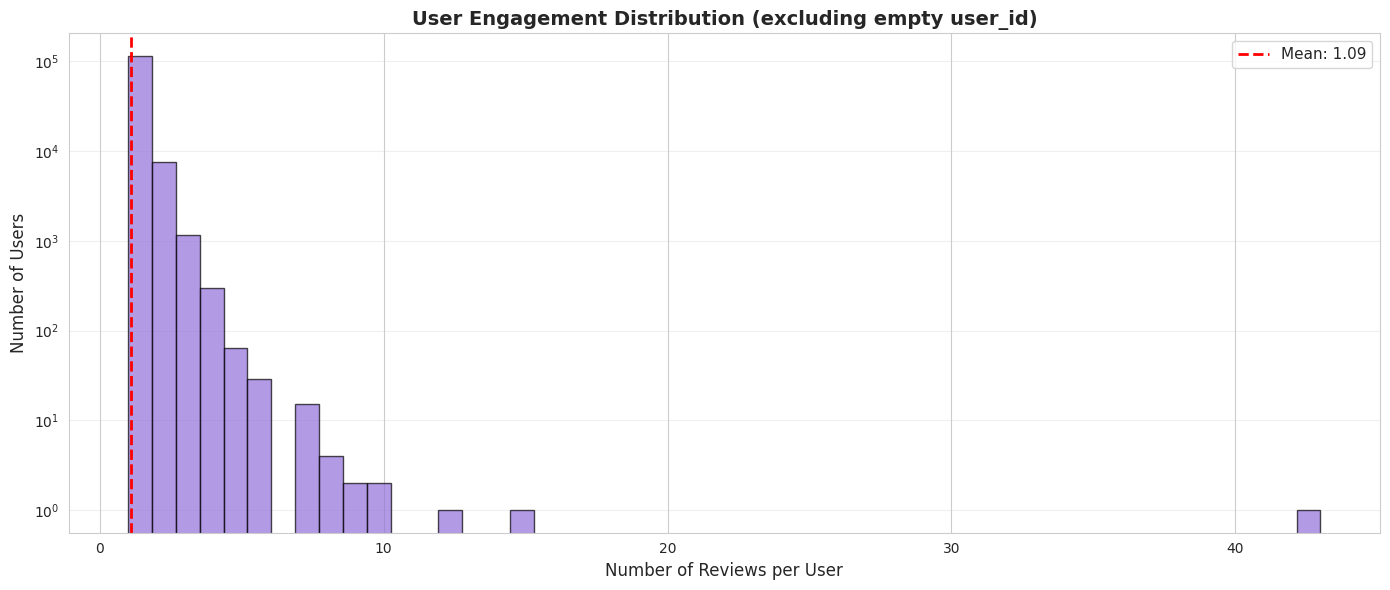


User Engagement Statistics (empty user_id excluded):
  Total active users: 123,560
  Mean reviews per user: 1.09
  Top reviewer: 43 reviews
  Users with only 1 review: 114,473 (92.6%)


In [22]:
# User engagement distribution (excluding empty user_id)
user_stats = pd.read_sql_query("""
    SELECT 
        user_id,
        COUNT(*) as review_count
    FROM reviews
    WHERE user_id != ''
    GROUP BY user_id
    ORDER BY review_count DESC
""", conn)

plt.figure(figsize=(14, 6))
plt.hist(user_stats['review_count'], bins=50, color='mediumpurple', alpha=0.7, edgecolor='black')
plt.xlabel('Number of Reviews per User', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('User Engagement Distribution (excluding empty user_id)', fontsize=14, fontweight='bold')
plt.yscale('log')  # Log scale because of long tail

mean_user_reviews = user_stats['review_count'].mean()
plt.axvline(mean_user_reviews, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_user_reviews:.2f}')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nUser Engagement Statistics (empty user_id excluded):")
print(f"  Total active users: {len(user_stats):,}")
print(f"  Mean reviews per user: {mean_user_reviews:.2f}")
print(f"  Top reviewer: {user_stats['review_count'].max()} reviews")
print(f"  Users with only 1 review: {(user_stats['review_count'] == 1).sum():,} ({(user_stats['review_count'] == 1).sum()/len(user_stats)*100:.1f}%)")

conn.close()

## 6. Create Sample Database for GitHub

For repository sharing, we'll create a smaller sample database (5,000 reviews) to:
- Reduce file size for GitHub
- Allow TAs to test the code
- Maintain representative data distribution

In [23]:
# Check if sample database already exists
sample_db_exists = os.path.exists(SAMPLE_DB_PATH)
print(f"Sample database exists: {sample_db_exists}")

if sample_db_exists:
    print("\n[!] Sample database already exists!")
    print("If you want to recreate it, delete the existing file first.")
else:
    print("\nReady to create sample database.")

Sample database exists: True

[!] Sample database already exists!
If you want to recreate it, delete the existing file first.


In [24]:
# Create sample database

processor = HotelReviewDataProcessor(DB_PATH)
processor.create_sample_database(
    sample_size=5000,
    output_path=SAMPLE_DB_PATH
)
processor.close()
print("[OK] Sample database created")

Creating sample database with 5000 reviews...
Sample database created: ../data/reviews_sample.db
[OK] Sample database created


In [25]:
# Verify sample database
sample_conn = sqlite3.connect(SAMPLE_DB_PATH)

sample_stats = pd.read_sql_query("""
    SELECT 
        (SELECT COUNT(*) FROM reviews) as reviews,
        (SELECT COUNT(*) FROM hotels) as hotels,
        (SELECT COUNT(*) FROM users) as users
""", sample_conn)

print("Sample Database Statistics:")
print("="*50)
display(sample_stats.T)

# Check file sizes
main_size = os.path.getsize(DB_PATH) / (1024**2)  # MB
sample_size_mb = os.path.getsize(SAMPLE_DB_PATH) / (1024**2)  # MB

print(f"\nFile Sizes:")
print(f"  Main database: {main_size:.2f} MB")
print(f"  Sample database: {sample_size_mb:.2f} MB")
print(f"  Size reduction: {(1 - sample_size_mb/main_size)*100:.1f}%")

sample_conn.close()

Sample Database Statistics:


,0
reviews,5000
hotels,1721
users,4695



File Sizes:
  Main database: 197.18 MB
  Sample database: 6.45 MB
  Size reduction: 96.7%


## 7. Summary

### Data Preparation Completed

**Dataset Characteristics:**
- **Time Range**: 2008-2012 (5 years)
- **Total Reviews**: ~75,500 (after filtering and 10% sampling)
- **Unique Hotels**: ~3,355
- **Unique Users**: ~67,560

**Filtering Decisions:**
1. **Year filter**: 2008-2012 (most recent complete data with good volume)
2. **Random sampling**: 10% of filtered data (to meet 50K-80K requirement)

**Database Design:**
- 3 normalized tables (`hotels`, `users`, `reviews`)
- 7 strategic indexes for query performance
- Foreign key relationships for data integrity

**Data Quality Assessment (6 Dimensions, NIH Thresholds):**
- **DataQualityAssessor** (ref: L1.2 Lab) -- 6 dimensions with NIH thresholds across all 3 tables
- Core fields (`rating_overall`, `text`, `hotel_id`): 100% complete
- `user_id`: 5.9% empty strings -- excluded from user-level analysis
- Sub-ratings: 10-33% NULL -- MNAR (optional fields), no imputation needed
- No duplicates, all validity checks passed, referential integrity intact

**Deliverables Created:**
- Main database: `data/reviews.db` (~75,500 reviews)
- Sample database: `data/reviews_sample.db` (5K reviews for GitHub)
- Processing code: `src/data_processing.py`
- This notebook documenting the entire process

### Next Steps:
1. **Exploratory Data Analysis** (`02_exploratory_analysis.ipynb`)
2. **Competitive Benchmarking** (`03_competitive_benchmarking.ipynb`)
3. **Performance Profiling** (`04_performance_profiling.ipynb`)